In [1]:
import cv2
import time
import numpy as np
from scipy.spatial import distance as dist
from imutils import face_utils
import dlib
import matplotlib.pyplot as plt
from pygame import mixer
mixer.init()
sound = mixer.Sound('./alarm.wav')

pygame 2.1.2 (SDL 2.0.18, Python 3.8.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 21
MOUTH_AR_THRESH = 0.4

SHOW_POINTS_FACE = True
SHOW_CONVEX_HULL_FACE = True
SHOW_INFO = True

X1 = []
ear = 0
mar = 0

In [3]:
face_cascade = cv2.CascadeClassifier("./cascade.xml")
eye_cascade = cv2.CascadeClassifier("./haarcascade_eye.xml")

In [4]:
COUNTER_FRAMES_EYE = 0
COUNTER_FRAMES_MOUTH = 0
COUNTER_BLINK = 0
COUNTER_MOUTH = 0

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

def mouth_aspect_ratio(mouth):
    A = dist.euclidean(mouth[5], mouth[8])
    B = dist.euclidean(mouth[1], mouth[11])	
    C = dist.euclidean(mouth[0], mouth[6])
    return (A + B) / (2.0 * C) 

No handles with labels found to put in legend.


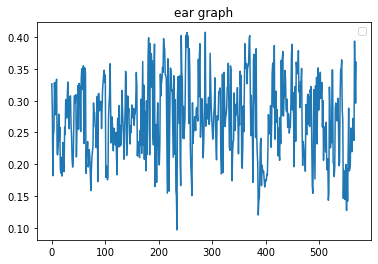

In [5]:
videoSteam = cv2.VideoCapture(0)
ret, frame = videoSteam.read()
size = frame.shape

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("C:/Users/Krishna Vamsi/Desktop/4-2 Courses/Project/Codes/dlib_shape_predictor/shape_predictor_68_face_landmarks.dat")
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

model_points = np.array([(0.0, 0.0, 0.0),
                         (0.0, -330.0, -65.0),        
                         (-225.0, 170.0, -135.0),     
                         (225.0, 170.0, -135.0),      
                         (-150.0, -150.0, -125.0),    
                         (150.0, -150.0, -125.0)])

focal_length = size[1]
center = (size[1]/2, size[0]/2)

camera_matrix = np.array([[focal_length, 0, center[0]],
                        [0, focal_length, center[1]],
                        [0, 0, 1]], dtype = "double")

dist_coeffs = np.zeros((4,1))

t_end = time.time()
while(True):
    ret, frame = videoSteam.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)

   #Detect faces through haarcascade_frontalface_default.xml
    face_rectangle = face_cascade.detectMultiScale(gray, 1.3, 5)

    #Draw rectangle around each face detected
    for (x,y,w,h) in face_rectangle:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]

    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        jaw = shape[48:61]

        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye) 
        ear = (leftEAR + rightEAR) / 2.0
        mar = mouth_aspect_ratio(jaw)
        X1.append(ear)
        image_points = np.array([
                                (shape[30][0], shape[30][1]),
                                (shape[8][0], shape[8][1]),
                                (shape[36][0], shape[36][1]),
                                (shape[45][0], shape[45][1]),
                                (shape[48][0], shape[48][1]),
                                (shape[54][0], shape[54][1])
                                ], dtype="double")


        (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
        (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

        if SHOW_POINTS_FACE:
            for p in image_points:
                cv2.circle(frame, (int(p[0]), int(p[1])), 3, (0,0,255), -1)

        p1 = (int(image_points[0][0]), int(image_points[0][1]))
        p2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
        
        if SHOW_CONVEX_HULL_FACE: 
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            jawHull = cv2.convexHull(jaw)

            

            cv2.drawContours(frame, [leftEyeHull], 0, (255, 255, 255), 1)
            cv2.drawContours(frame, [rightEyeHull], 0, (255, 255, 255), 1)
            cv2.drawContours(frame, [jawHull], 0, (255, 255, 255), 1)
            cv2.line(frame, p1, p2, (255,255,255), 2)


        if p2[1] > p1[1]*1.5 or COUNTER_BLINK > 25 or COUNTER_MOUTH > 2:
            cv2.putText(frame, "Send Alert!", (200, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            
        if ear < EYE_AR_THRESH:
            COUNTER_FRAMES_EYE += 1

            if COUNTER_FRAMES_EYE >= EYE_AR_CONSEC_FRAMES:
                cv2.putText(frame, "Sleeping Driver!", (200, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                sound.play()
                time.sleep(0.5)
                sound.stop()

        else:
            if COUNTER_FRAMES_EYE > 2:
                COUNTER_BLINK += 1
            COUNTER_FRAMES_EYE = 0
        
        if mar >= MOUTH_AR_THRESH:
            COUNTER_FRAMES_MOUTH += 1
        else:
            if COUNTER_FRAMES_MOUTH > 5:
                COUNTER_MOUTH += 1
      
            COUNTER_FRAMES_MOUTH = 0
        
        if (time.time() - t_end) > 60:
            t_end = time.time()
            COUNTER_BLINK = 0
            COUNTER_MOUTH = 0
        
    if SHOW_INFO:
        cv2.putText(frame, "EAR: {:.2f}".format(ear), (30, 450),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(frame, "MAR: {:.2f}".format(mar), (200, 450),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(frame, "Blinks: {}".format(COUNTER_BLINK), (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(frame, "Mouths: {}".format(COUNTER_MOUTH), (10, 60),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    cv2.imshow("Output", frame)

    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break
    if key == ord('p'):
        SHOW_POINTS_FACE = not SHOW_POINTS_FACE
    if key == ord('c'):
        SHOW_CONVEX_HULL_FACE = not SHOW_CONVEX_HULL_FACE
    if key == ord('i'):
        SHOW_INFO = not SHOW_INFO
    time.sleep(0.02)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(X1)
plt.title('ear graph')
ax.legend()
fig.savefig('ear.png')   
videoSteam.release()  
cv2.destroyAllWindows()